In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from tips.io import load_ds

tunit = 1/100.
eunit = 1.0
natom = 640

def plot_energies(ax, ds, init, color):
    e_bias = np.array([d['energy_bias'] for d in ds])/640
    e_avg = np.array([d['energy_avg'] for d in ds])/640
    e_std = np.array([d['energy_std'] for d in ds])/640
    t = np.arange(len(e_std))*tunit
    # ax.text(t[-1], e_avg[-1], init, ha='right')
    l1 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=color, alpha=0.5)
    l2, = ax.plot(t, e_avg, color=color, lw=1)
    # l3 = ax.plot(t, e_avg+e_bias, 'k:', lw=1)
    return (l1,l2) #, l3

def doplots():
    for ftraj in glob(f'../{name}/emd/gen{gen}/*/asemd.traj'):
        init = Path(ftraj).parent.name
        traj = load_ds(ftraj, fmt='asetraj', index=':')
        l1 = plot_energies(ax1, traj, init, 'tab:green')
        l2 = None
        try:
            idx = np.loadtxt(f'../{name}/merge/gen{gen}/{init}/merged.idx')
            sort = np.argsort(idx)[:2]
            idx = idx[sort]
            e_model = np.array([traj[int(i)]['energy_avg'] for i in idx]) / natom
            f_model = np.array([traj[int(i)]['force_avg'] for i in idx])
            label = load_ds(f'../{name}/merge/gen{gen}/{init}/merged.traj', fmt='asetraj')
            e_label = np.array([l['energy'] for l in label])[sort] * eunit / natom
            f_label = np.array([l['force'] for l in label])[sort] * eunit
            print(f"{name}/gen{gen}/{init:15s}",
                  f"e_rmse: {np.sqrt(np.mean((e_model-e_label)**2)):6.2f}, ",
                  f"f_rmse: {np.sqrt(np.mean((f_model-f_label)**2)):6.2f}, ",
                  f"e_max: {np.max(np.abs(e_model-e_label)):6.2f}, ",
                  f"f_max: {np.max(np.abs(f_model-f_label)):6.2f}",
                 )
            l2, = ax1.plot(idx[sort]*tunit, e_label[sort], 'x--', ms=3, lw=1, color='tab:red')
            ax2.scatter(e_model, e_label, color='tab:red', s=5,ec=None)
            emin, emax = -125.25, -124.95
            ax2.plot([emin, emax], [emin, emax], ':', lw=1, color='gray')
            ax2.set_xlim(emin, emax)
            ax2.set_ylim(emin, emax)        
            fmin, fmax = -10,10
            ax3.scatter(f_model, f_label, color='tab:red', s=1,ec=None)
            ax3.plot([fmin, fmax], [fmin, fmax], ':', lw=1, color='gray')
            ax3.set_xlim(fmin, fmax)
            ax3.set_ylim(fmin, fmax)
        except:
            pass
    
    ax1.set_xlabel('time [ps]')
    ax1.set_title(title, fontsize=10)
    ax1.set_ylim(-125.25, -124.95)
    ax2.set_xlabel('$E_{pred}~[eV/atom]$')
    ax3.set_xlabel('$F_{pred}~[eV/\AA]$')
    return l1, l2
    


exp/ekf-v2/gen0/m16i16-r1.16    e_rmse:   0.01,  f_rmse:   0.55,  e_max:   0.02,  f_max:   3.17
exp/ekf-v2/gen0/m0i32-r1.16     e_rmse:   0.01,  f_rmse:   0.54,  e_max:   0.02,  f_max:   3.07
exp/ekf-v2/gen0/m32i0-r1.08     e_rmse:   0.01,  f_rmse:   0.56,  e_max:   0.02,  f_max:   3.65
exp/ekf-v2/gen0/m16i16-r1.08    e_rmse:   0.01,  f_rmse:   0.56,  e_max:   0.02,  f_max:   3.40
exp/ekf-v2/gen0/m32i0-r1.16     e_rmse:   0.01,  f_rmse:   0.56,  e_max:   0.02,  f_max:   4.43
exp/ekf-v2/gen0/m0i32-r1.08     e_rmse:   0.01,  f_rmse:   0.55,  e_max:   0.02,  f_max:   4.07


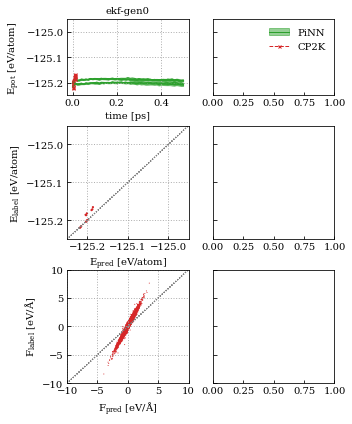

In [22]:
f, axs = plt.subplots(3,2, figsize=[5,6], sharey='row', gridspec_kw={'height_ratios': [2,3,3]})
for (name, gen, title), (ax1, ax2, ax3) in zip([
    #['exp/ekf-nobias',2, 'ekf-gen2'],
    #['exp/adam-v2',0, 'adam-gen0'],
    ['exp/ekf-v2',0, 'ekf-gen0']
    
], axs.T):
    l1, l2 = doplots()
    ax1.grid(lw=1, ls=':')
    ax2.grid(lw=1, ls=':')
    ax3.grid(lw=1, ls=':')
axs[0,1].legend([l1,l2], ['PiNN', 'CP2K'],facecolor='w',frameon=True,edgecolor='none')
axs[0,0].set_ylabel('$E_{pot}~[eV/atom]$')
axs[1,0].set_ylabel('$E_{label}~[eV/atom]$')
axs[2,0].set_ylabel('$F_{label}~[eV/\AA]$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig('al-adam-gen5.png')

In [14]:
# some normal conversion for visualization
from tips.io import load_ds
traj = load_ds('../exp/adam-bias1/emd/gen1/m16i16-r1.08/asemd.traj',fmt='asetraj')
traj.convert('tmp.xyz', fmt='extxyz')

40ps-EKF@300K
--------------------
40ps-Adam@300K
--------------------
ALGen3-Adam@340K
--------------------


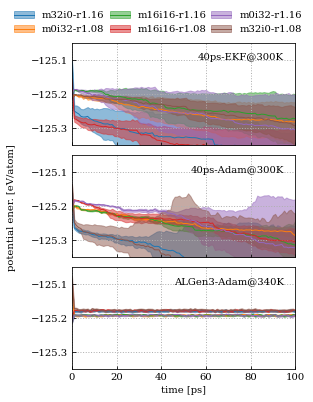

In [82]:
f, axs = plt.subplots(3,1, figsize=[4,6], sharex=True, sharey=True)
handles, labels = [], []
stride = 100
for tag, match, ax in zip(['40ps-EKF@300K', '40ps-Adam@300K', 'ALGen3-Adam@340K'],
                          ['nvt-300k-100ps/pils-v6-pinet-ekf-*',
                           'nvt-300k-100ps/pils-v6-pinet-adam-*',
                           'al-adam/nvt-340k-100ps/*'],
                          axs):
    print(tag)
    ax.text(0.95, 0.9, tag, transform=ax.transAxes, ha='right', va='top')
    for fname in glob(f'../trajs/ase/{match}/asemd.traj'):
        init = '-'.join(Path(fname).parent.name.split('-')[-2:])
        ds = load_ds(fname,fmt='asetraj', index=f'::{stride}')
        e_avg = np.array([datum['energy_avg'] for datum in ds])/natom
        e_std = np.array([datum['energy_std'] for datum in ds])/natom
        t = np.arange(len(e_avg))*0.01*stride
        l1, = ax.plot(t, e_avg, lw=1)
        l2 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=l1.get_color(), alpha=0.5)
        handles.append((l1,l2))
        labels.append(init)
        
        if ax==axs[0]:
            ax.legend(handles, labels, ncol=3, loc=3, bbox_to_anchor=[-0.3,1], columnspacing=0.5)
        elif ax==axs[-1]:
            ax.set_xlabel('time [ps]')
        ax.set_ylim(-125.35, -125.05)
        ax.set_xlim(0,100)
        ax.grid(b=True,lw=1, ls=':')
    print("-"*20)
f.text(-0.1, 0.5, 'potential ener. [eV/atom]', va='center',rotation='vertical')
f.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig('pils-v6-models.pdf')

In [83]:
traj = load_ds('../trajs/ase/al-adam/nvt-340k-100ps/m32i0-r1.16/asemd.traj',fmt='asetraj', index='::100')
traj.convert('tmp.xyz', fmt='extxyz')